# Regional volume scaling of the Millan thicknesses 

This notebook contains the code to realize three main tasks:

1. In a first step, we reproduce Table 1 in M22 by reading all geotiff files provided on the data repository and computing the total area and volume covered by the dataset. We are able to reproduce the numbers in the table withing a few percent. However, there are a few differences we attempt to clarify.
2. Using the glacier-per-glacier scripts in OGGM, we reproject the M22 data to each glacier infividually and compute their volume based on the M22 data. We then compare the same area in the M22 and F19 dataset to assess the true difference between the two datasets, and use this number to upscale the missing glacier volume at the regional scale. The underlying assumption of this method is that the F19 product provides a good estimate of fraction of the regional volume which is located in the areas not covered by the M22 dataset.
3. For completeness, we us a simpler method which simply scales by the missing area, assuming linear scaling between volume and area. The results are comparable.

We detail each of the precedures below.

This notebook has been run on the cluster in Bremen, but all the data necessary to run it is available at the following urls:
- https://cluster.klima.uni-bremen.de/~oggm/velocities/millan22/ downloaded from https://www.sedoo.fr/theia-publication-products/?uuid=55acbdd5-3982-4eac-89b2-46703557938c
- https://cluster.klima.uni-bremen.de/~oggm/g2ti/ downloaded from https://www.research-collection.ethz.ch/handle/20.500.11850/315707
- https://cluster.klima.uni-bremen.de/~oggm/rgi/ downloaded from https://www.glims.org/RGI/

In [1]:
import zipfile
import glob
import numpy as np
import pandas as pd
import geopandas as gpd
import rioxarray as rioxr
from scipy import stats
import progressbar
import matplotlib.pyplot as plt

## Part 1: reproduce M22's Table 1 based on the available data 

### Input files 

Read the list of files available in the data repository:

In [2]:
def open_zip_shapefile(fpath, exclude_pattern='', include_pattern=''):
    with zipfile.ZipFile(fpath, "r") as z:
        for f in z.filelist:
            if f.filename.endswith('.shp'):
                if exclude_pattern and exclude_pattern in f.filename:
                    continue
                if include_pattern and include_pattern not in f.filename:
                    continue
                fname = f.filename
                
    return gpd.read_file('zip://' + fpath + '/' + fname)

gdf = open_zip_shapefile('/home/www/oggm/velocities/millan22/millan22_thickness_lookup_shp.zip')

In [3]:
gdf

,rgi_reg,file_id,thickness,err,geometry
0,01,RGI-1.1_2021July01,thickness/RGI-1/THICKNESS_RGI-1.1_2021July01.tif,thickness/RGI-1/ERRTHICKNESS_RGI-1.1_2021July0...,"POLYGON ((-155.21725 63.25339, -155.21628 63.2..."
1,01,RGI-1.2_2021July01,thickness/RGI-1/THICKNESS_RGI-1.2_2021July01.tif,thickness/RGI-1/ERRTHICKNESS_RGI-1.2_2021July0...,"POLYGON ((-167.27902 55.62410, -167.27822 55.6..."
2,01,RGI-1.3_2021July01,thickness/RGI-1/THICKNESS_RGI-1.3_2021July01.tif,thickness/RGI-1/ERRTHICKNESS_RGI-1.3_2021July0...,"POLYGON ((-160.52884 60.45355, -160.52793 60.4..."
3,01,RGI-1.4_2021July08,thickness/RGI-1/THICKNESS_RGI-1.4_2021July08.tif,thickness/RGI-1/ERRTHICKNESS_RGI-1.4_2021July0...,"POLYGON ((-156.64318 68.20145, -156.64202 68.2..."
4,01,RGI-1.5_2021July01,thickness/RGI-1/THICKNESS_RGI-1.5_2021July01.tif,thickness/RGI-1/ERRTHICKNESS_RGI-1.5_2021July0...,"POLYGON ((-149.06528 69.27784, -149.06403 69.2..."
...,...,...,...,...,...
56,19,RGI-19.1_2021July09,thickness/RGI-19/THICKNESS_RGI-19.1_2021July09...,thickness/RGI-19/ERRTHICKNESS_RGI-19.1_2021Jul...,"POLYGON ((-37.96839 -54.01246, -37.96763 -54.0..."
57,19,RGI-19.2_2021July09,thickness/RGI-19/THICKNESS_RGI-19.2_2021July09...,thickness/RGI-19/ERRTHICKNESS_RGI-19.2_2021Jul...,"POLYGON ((68.78110 -49.03347, 68.78179 -49.033..."
58,19,RGI-19.3_2021July09,thickness/RGI-19/THICKNESS_RGI-19.3_2021July09...,thickness/RGI-19/ERRTHICKNESS_RGI-19.3_2021Jul...,"POLYGON ((73.25417 -52.98885, 73.25491 -52.988..."
59,19,RGI-19.4_2021July09,thickness/RGI-19/THICKNESS_RGI-19.4_2021July09...,thickness/RGI-19/ERRTHICKNESS_RGI-19.4_2021Jul...,"POLYGON ((-46.12427 -60.47823, -46.12336 -60.4..."


There are 61 files for the globe:

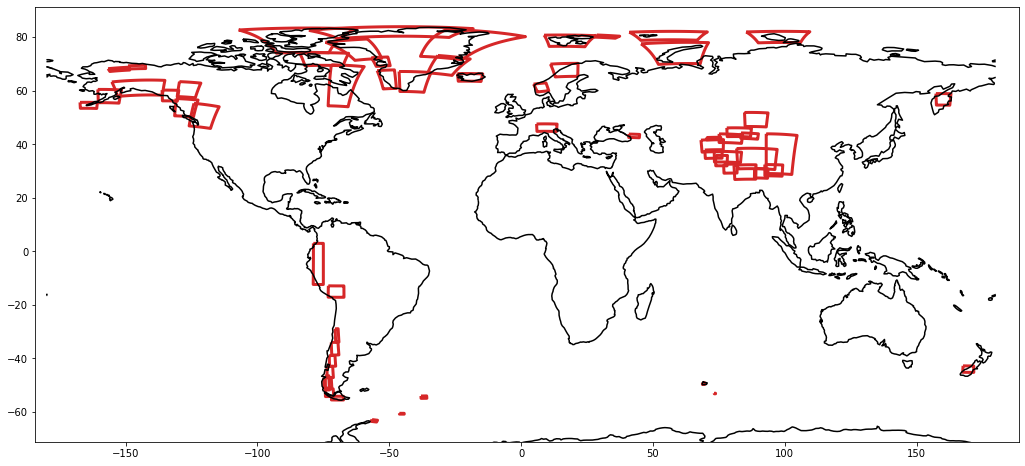

In [4]:
f, ax = plt.subplots(figsize=(18, 8))

gdf.plot(ax=ax, facecolor='none', edgecolor='C3', linewidth=3);
    
ax.autoscale(enable=False, axis='both', tight=True)

data_dir = '/home/www/fmaussion/misc/rgi7_data'
fpath = f'{data_dir}/l0_support_data/ne_110m_coastline.zip'
coast_lr = open_zip_shapefile(fpath)
coast_lr.plot(ax=ax, facecolor='none', edgecolor='k', aspect=None);

In [5]:
# We don't need the errors or the geometries for now
gdf = gdf.drop(['err', 'geometry'], axis=1)

### Compute volume

In [6]:
# For each file, compute the total volume and area coverage
for i, s in progressbar.progressbar(gdf.iterrows(), max_value=len(gdf)):
    with rioxr.open_rasterio('/home/www/oggm/velocities/millan22/' + s['thickness']) as ds:
        # Read and convert to float64 for precision
        ds = ds.isel(band=0).astype(np.float64)
        # Replace NaNs with 0
        ds = ds.where(~ ds.isnull(), 0)
        if ds.max() == np.inf:
            # Replace inf with 0
            ds = ds.where(ds != ds.max(), 0)
        # Replace negative values with 0
        ds = ds.where(ds >= 0, 0)
        # dx dy (always 50)
        dx = abs(float(ds.x[1] - ds.x[0]))
        dy = abs(float(ds.y[1] - ds.y[0]))
        # Area and volume
        area_km2 = (ds > 0).sum() * dx * dy * 1e-6
        vol_km3 = ds.sum() * dx * dy * 1e-9
    gdf.loc[i, 'area_km2'] = area_km2
    gdf.loc[i, 'vol_km3'] = vol_km3

100% (61 of 61) |########################| Elapsed Time: 0:12:08 Time:  0:12:08


In [25]:
gdf.head()

,rgi_reg,file_id,thickness,area_km2,vol_km3
0,01,RGI-1.1_2021July01,thickness/RGI-1/THICKNESS_RGI-1.1_2021July01.tif,69453.0025,14616.413421
1,01,RGI-1.2_2021July01,thickness/RGI-1/THICKNESS_RGI-1.2_2021July01.tif,380.3375,49.725438
2,01,RGI-1.3_2021July01,thickness/RGI-1/THICKNESS_RGI-1.3_2021July01.tif,1467.6525,163.143965
3,01,RGI-1.4_2021July08,thickness/RGI-1/THICKNESS_RGI-1.4_2021July08.tif,52.3250,2.735332
4,01,RGI-1.5_2021July01,thickness/RGI-1/THICKNESS_RGI-1.5_2021July01.tif,251.9525,20.450344


In [26]:
# Aggregate per RGI Region
gdfs = gdf.groupby('rgi_reg').sum()

# Region 01 and 02 are merge in Millan because the files overlap
gdfs.loc['01'] = gdfs.loc[['01', '02']].sum()
# Region 19 is a mix of these files and the other, just ignore
gdfs = gdfs.drop(['02', '19'])
gdfs

,area_km2,vol_km3
rgi_reg,,
01,101399.5050,19151.015559
03,104315.5400,25302.473587
04,38130.0000,7006.831013
05,84478.8475,11764.564517
06,11017.5675,3726.328227
07,33822.0550,6994.924888
08,2694.1575,288.951620
09,49695.6375,15501.162732
10,1792.4075,108.789819


Now compare to the data in the paper:

In [27]:
df_paper = pd.read_csv('data/m22.csv', index_col=0)
df_paper_aa = df_paper.loc['19'].copy()
df_paper_total = df_paper.loc['Total'].copy()
df_paper = df_paper.drop(['19', '19*', 'Total'])  #  Drops the useless one
df_paper

,A,V,V_err,SLE,SLE_err
RGI_Reg,,,,,
"01, 02",101,19.20,5.60,46.40,15.3
03,105,25.40,7.20,59.90,19.2
04,41,7.00,2.10,17.70,5.8
05,90,11.80,3.70,26.80,9.5
06,11,3.70,0.90,9.40,2.6
07,34,7.00,2.30,15.40,5.7
08,3,0.29,0.10,0.73,0.3
09,52,15.50,3.90,33.70,9.6
10,3,0.09,0.05,0.22,0.1


The paper provides rounded numbers, so we do the same:

In [28]:
df_paper['Our_V'] = np.round(gdfs['vol_km3'] * 1e-3, 2).values
toprint = df_paper[['V', 'Our_V']]
toprint.columns = ['Volume M22 Table 1 (10^3 km3)', 'Computed Volume (10^3 km3, rounded)']
toprint.to_html('/home/www/oggm/velocities/millan22/_checks/computed_volume.html')
toprint

,Volume M22 Table 1 (10^3 km3),"Computed Volume (10^3 km3, rounded)"
RGI_Reg,,
"01, 02",19.20,19.15
03,25.40,25.30
04,7.00,7.01
05,11.80,11.76
06,3.70,3.73
07,7.00,6.99
08,0.29,0.29
09,15.50,15.50
10,0.09,0.11


OK, close enough (not perfect but close enough). **Largest % difference is RGI10, which I cannot explain easily**.

Let's also check the global numbers:

In [29]:
df_paper.sum().loc[['V', 'Our_V']] + df_paper_aa['V']

V        140.90
Our_V    140.51
dtype: float64

In [30]:
df_paper_total['V']

140.8

OK, good enough. Now, let's add F19 to the mix:

In [31]:
rgi = pd.read_hdf('/home/www/oggm/rgi/rgi62_stats.h5')
rgi = rgi.loc[rgi.Connect != 2]
f19 = pd.read_hdf('/home/www/oggm/g2ti/rgi62_era5_itmix_df.h5')
rgi = rgi[['O1Region', 'Connect', 'Area']].copy()
rgi['f19_vol_km3'] = f19['vol_itmix_m3'] * 1e-9
rgi.head()

,O1Region,Connect,Area,f19_vol_km3
RGIId,,,,
RGI60-01.00001,01,0,0.360,0.007639
RGI60-01.00002,01,0,0.558,0.016976
RGI60-01.00003,01,0,1.685,0.059693
RGI60-01.00004,01,0,3.681,0.195225
RGI60-01.00005,01,0,2.573,0.122154


In [32]:
f19 = rgi.groupby('O1Region').sum()[['Area', 'f19_vol_km3']]
# Convert data units and redo the region shenanigans necessary
f19.loc['13'] = f19.loc[['13', '14', '15']].sum()
f19.loc['01'] = f19.loc[['01', '02']].sum()
f19_aa = f19.loc['19']
f19 = f19.drop(['02', '14', '15', '19'])
f19

,Area,f19_vol_km3
O1Region,,
01,101249.277,20025.246235
03,105110.642,28331.244808
04,40888.228,8611.334844
05,89717.066,15692.033459
06,11059.700,3769.573579
07,33958.934,7470.376413
08,2949.103,298.508990
09,51591.600,14640.222360
10,2410.051,135.781117


Now compare with the F19 paper table to be sure: 

In [33]:
df_paper = pd.read_csv('data/f19.csv', index_col=0)
df_paper.loc['13'] = df_paper.loc[['13', '14', '15']].sum()
df_paper.loc['01'] = df_paper.loc[['01', '02']].sum()
df_paper = df_paper.drop(['02', '14', '15', '19', 'Total'])

In [34]:
df_paper['Our_V'] = np.round(f19['f19_vol_km3'] * 1e-3, 2).values
df_paper[['V', 'Our_V']]

,V,Our_V
RGI_Reg,,
01,20.04,20.03
03,28.33,28.33
04,8.61,8.61
05,15.69,15.69
06,3.77,3.77
07,7.47,7.47
08,0.30,0.30
09,14.64,14.64
10,0.14,0.14


Almost perfect! 

In [35]:
df_paper['Our_A'] = np.round(f19['Area'], 2).values
df_paper[['A', 'Our_A']]

,A,Our_A
RGI_Reg,,
01,101306,101249.28
03,104920,105110.64
04,40860,40888.23
05,89651,89717.07
06,11052,11059.70
07,33932,33958.93
08,2947,2949.10
09,51551,51591.60
10,2399,2410.05


Yeah, more or less. No clue what went wrong in some regions (I assume summation errors on floats), but its not too bad. Our areas are the correct ones.

**Now Merge everything together:**

In [36]:
odf = gdfs.copy()
odf.columns = ['millan_area_km2', 'millan_vol_km3']
odf[['f19_area_km2', 'f19_vol_km3']] = f19

In [37]:
odf

,millan_area_km2,millan_vol_km3,f19_area_km2,f19_vol_km3
rgi_reg,,,,
01,101399.5050,19151.015559,101249.277,20025.246235
03,104315.5400,25302.473587,105110.642,28331.244808
04,38130.0000,7006.831013,40888.228,8611.334844
05,84478.8475,11764.564517,89717.066,15692.033459
06,11017.5675,3726.328227,11059.700,3769.573579
07,33822.0550,6994.924888,33958.934,7470.376413
08,2694.1575,288.951620,2949.103,298.508990
09,49695.6375,15501.162732,51591.600,14640.222360
10,1792.4075,108.789819,2410.051,135.781117


In [38]:
# Compute the differences
odf['area_cov'] = odf['millan_area_km2'] / odf['f19_area_km2'] * 100
odf['vol_diff'] = odf['millan_vol_km3'] / odf['f19_vol_km3'] * 100 - 100

In [39]:
# Make index more correct
ide = np.array(odf.index)
ide[0] = '01-02'
ide[11] = '13-15'
odf.index = ide

In [40]:
odf

,millan_area_km2,millan_vol_km3,f19_area_km2,f19_vol_km3,area_cov,vol_diff
01-02,101399.5050,19151.015559,101249.277,20025.246235,100.148374,-4.365643
03,104315.5400,25302.473587,105110.642,28331.244808,99.243557,-10.690569
04,38130.0000,7006.831013,40888.228,8611.334844,93.254225,-18.632464
05,84478.8475,11764.564517,89717.066,15692.033459,94.161402,-25.028426
06,11017.5675,3726.328227,11059.700,3769.573579,99.619045,-1.147221
07,33822.0550,6994.924888,33958.934,7470.376413,99.596928,-6.364492
08,2694.1575,288.951620,2949.103,298.508990,91.355151,-3.201702
09,49695.6375,15501.162732,51591.600,14640.222360,96.325056,5.880651
10,1792.4075,108.789819,2410.051,135.781117,74.372181,-19.878536
11,2078.8075,116.196218,2092.146,127.924280,99.362449,-9.167972


### Compare area coverage and volume difference with paper table 

https://www.nature.com/articles/s41561-021-00885-z/tables/1

In [41]:
cov_from_paper = [96, 99, 100, 100, 99, 97, 84, 98, 63, 99, 78, 100, 82, 99, 99]
vol_diff_from_paper = [-4, -10, -19, -25, -1, -6, -4, 6, -35, -11, -8, 37, -27, 10, 2]

In [42]:
comp = odf[['area_cov']].round(0).astype(int)
comp.columns = ['our_area_cov']
comp['paper_area_cov'] = cov_from_paper
comp

,our_area_cov,paper_area_cov
01-02,100,96
03,99,99
04,93,100
05,94,100
06,100,99
07,100,97
08,91,84
09,96,98
10,74,63
11,99,99


**The discrepancies arise because the coverage reported is that of velocity data: NOT thickness. After the velocity data, some filtering, gap filling, and extrapolating happens, which increases (sometimes decreases) the coverage.** 

In [43]:
comp = odf[['vol_diff']].round(0).astype(int)
comp.columns = ['our_vol_diff']
comp['paper_vol_diff'] = vol_diff_from_paper
comp

,our_vol_diff,paper_vol_diff
01-02,-4,-4
03,-11,-10
04,-19,-19
05,-25,-25
06,-1,-1
07,-6,-6
08,-3,-4
09,6,6
10,-20,-35
11,-9,-11


This matches very well, with a few exceptions: 
- RGI10, RGI12: these are small regions and this may happen because of rounding + a little weirdness in region 10 (I demonstrate it below)
- RGI13-15: this is because our volume is slightly lower than in the paper, and I don't know why

In [44]:
# Example of rounding simplification:
m22_10 = 108.789819
f19_10 = 135.781117
1 - m22_10 / f19_10, 1 - 0.09 / 0.14

(0.19878535834993905, 0.3571428571428572)

Also compare the global numbers:

In [45]:
aa = pd.Series(index=['millan_vol_km3', 'f19_vol_km3'], data=[df_paper_aa['V']*1e3, f19_aa['f19_vol_km3']])
total = odf[['millan_vol_km3', 'f19_vol_km3']].sum() + aa
total

millan_vol_km3    140518.240952
f19_vol_km3       158156.598376
dtype: float64

In [46]:
df_paper_total['V'], 1 - total['millan_vol_km3'] / total['f19_vol_km3']

(140.8, 0.11152463827301962)

OK that's consistent. 

### Quick analysis 

Just a plot to show that there is a correlation between missing area and volume difference. It's not all the story, but part of it:

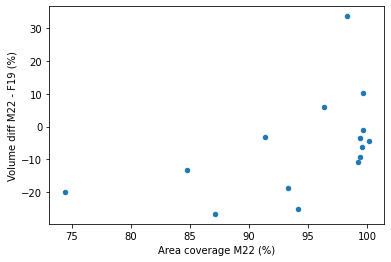

In [47]:
import matplotlib.pyplot as plt

odf.plot.scatter(x='area_cov', y='vol_diff');
plt.xlabel('Area coverage M22 (%)');
plt.ylabel('Volume diff M22 - F19 (%)');

## Part 2: upscale regional results to account for missing area 

We started by computing a glacier-per-glacier volume based on Millan data. For this we use OGGM and a [recently added tool](https://github.com/OGGM/oggm/pull/1443) to read and reproject M22 data to each glacier map. Let's read in the tabular products:

In [48]:
all_files = glob.glob('/home/www/fmaussion/runs/try_millan_on_gla/output/RGI*.csv')
df_all = pd.concat((pd.read_csv(f, index_col=0) for f in all_files))
df_all = df_all.sort_index()
df_all['rgi_region'] = [f'{r:02}' for r in df_all['rgi_region']]
assert len(df_all) == len(rgi)
df_all['f19_vol_km3'] = rgi['f19_vol_km3']

In [49]:
df_all.head()

,rgi_region,rgi_subregion,rgi_area_km2,millan_vol_km3,millan_area_km2,millan_perc_cov,f19_vol_km3
rgi_id,,,,,,,
RGI60-01.00001,01,01-02,0.360,0.009056,0.360288,1.000800,0.007639
RGI60-01.00002,01,01-02,0.558,0.024511,0.552000,0.989247,0.016976
RGI60-01.00003,01,01-02,1.685,0.082079,1.675408,0.994307,0.059693
RGI60-01.00004,01,01-02,3.681,0.178784,3.677134,0.998950,0.195225
RGI60-01.00005,01,01-02,2.573,0.000000,0.000000,0.000000,0.122154


### Example RGI16

Let's take RGI16 as an example:

In [82]:
df_sel = df_all.loc[df_all['rgi_region'] == '16'].copy()
len(df_sel)

2939

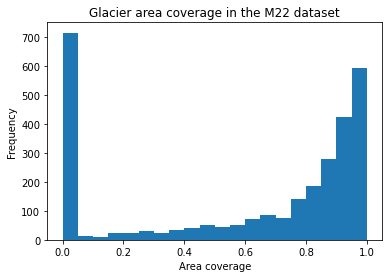

In [83]:
df_sel['millan_perc_cov'].plot(kind='hist', bins=np.linspace(0, 1, 21));
plt.xlabel('Area coverage'); plt.title('Glacier area coverage in the M22 dataset'); 

In [84]:
(df_sel['millan_perc_cov'] == 0).sum(), (df_sel['millan_perc_cov'] < 0.9).sum(), (df_sel['millan_perc_cov'] >= 0.9).sum()

(699, 1891, 1048)

Out of 2939 glaciers, 699 have no data at all and 1430 have less then 90% coverage.

Now let's see how much volume could not be asssigned to a glacier at all (this happens because of vector to raster conversions, and of a slight shift in the M22 data).

In [85]:
df_sel['millan_vol_km3'].sum(), odf.loc['16']['millan_vol_km3'], odf.loc['16']['millan_vol_km3'] / df_sel['millan_vol_km3'].sum()

(69.0635936423445, 72.15701827322675, 1.0447909595741858)

This means that we are missing about 4% of the total volume, which is reasonable. For good measure, we will simply adjust all individual volumes by 4%:

In [86]:
df_sel['millan_vol_km3_adj'] = df_sel['millan_vol_km3'] * odf.loc['16']['millan_vol_km3'] / df_sel['millan_vol_km3'].sum()

Now, let's compare apples with apples: we pick all glaciers which have a sufficient data coverage (say 95%) and compare M22 with F19 **for these glaciers only**:

In [87]:
df_ok = df_sel.loc[df_sel['millan_perc_cov'] >= 0.95]
df_ok = df_ok.sum()
df_ok.loc[['millan_vol_km3_adj', 'f19_vol_km3']]

millan_vol_km3_adj    56.430999
f19_vol_km3           66.113904
dtype: object

Assuming that this ratio stays the same at the regional level, the new regional volume therefore needs to be:

In [88]:
corr_vol = df_sel['f19_vol_km3'].sum() * df_ok.loc['millan_vol_km3_adj'] / df_ok.loc['f19_vol_km3']
corr_vol

83.95708282506645

In [89]:
corr_vol /  odf.loc['16']['millan_vol_km3'], corr_vol / odf.loc['16']['f19_vol_km3'] - 1

(1.1635331508178188, -0.14645793194908863)

**Which is a correction of about 14% to the originally announced volume, and revises the originally announced -27% to -16%**

### Sensitivity to the 95% threshold 

In [90]:
for thres in [0.7, 0.8, 0.9, 0.95]:
    df_ok = df_sel.loc[df_sel['millan_perc_cov'] > thres]
    df_ok = df_ok.sum()
    print(thres, df_ok.loc['millan_vol_km3_adj'] / df_ok.loc['f19_vol_km3'] - 1)

0.7 -0.16876655137769225
0.8 -0.1653310706735588
0.9 -0.15815382694690738
0.95 -0.14645793194908863


It does make a difference, but only $\pm$ 1% 

### Global correction, region per region

In [138]:
perc_threshold = 0.95

In [139]:
fodf = odf.copy()

all_adjusted = []
for reg in fodf.index:
    
    # Special cases
    if reg == '01-02':
        regs = ['01', '02']
    elif reg == '13-15':
        regs = ['13', '14', '15']
    else:
        regs = [reg]
    
    # Regional selection
    df_sel = df_all.loc[df_all['rgi_region'].isin(regs)].copy()
    
    # We adjust the individual glacier volumes to count for area that's not in a glacier mask
    # This oscillates between 0 and 5%
    cor_fac_for_cov = fodf.loc[reg]['millan_vol_km3'] / df_sel['millan_vol_km3'].sum()
    df_sel['millan_vol_km3_adj'] = df_sel['millan_vol_km3'] * cor_fac_for_cov
    
    # Subsest of glaciers with good coverage
    df_sel_subset = df_sel.loc[df_sel['millan_perc_cov'] >= perc_threshold]
    df_sel_subset_sum = df_sel_subset.sum()
    
    cor_fac_for_vol = df_sel_subset_sum.loc['millan_vol_km3_adj'] / df_sel_subset_sum.loc['f19_vol_km3']
    fodf.loc[reg, 'vol_subset_m22'] = df_sel_subset_sum.loc['millan_vol_km3_adj']
    fodf.loc[reg, 'vol_subset_f19'] = df_sel_subset_sum.loc['f19_vol_km3']
    fodf.loc[reg, 'vol_subset_cov'] = df_sel_subset_sum.loc['millan_vol_km3_adj'] / fodf.loc[reg]['millan_vol_km3']
    fodf.loc[reg, 'vol_diff_on_subset'] = (cor_fac_for_vol - 1) * 100
    
    vol_corrected = df_sel['f19_vol_km3'].sum() * cor_fac_for_vol
    fodf.loc[reg, 'millan_vol_km3_corrected'] = vol_corrected
    
    # VAS
    # Fit in log space 
    dfl = np.log(df_sel_subset[['millan_vol_km3_adj', 'rgi_area_km2']])
    slope, intercept, _, _, _ = stats.linregress(dfl.rgi_area_km2.values, dfl.millan_vol_km3_adj.values)
    c = np.exp(intercept)
    gamma = slope
    df_sel['vas_millan_vol'] = c * df_sel['rgi_area_km2'] ** gamma
    fodf.loc[reg, 'vas_param_c'] = c
    fodf.loc[reg, 'vas_param_gamma'] = gamma
    fodf.loc[reg, 'millan_vol_km3_vas_corrected'] = df_sel_subset_sum['millan_vol_km3_adj'] + df_sel.loc[df_sel['millan_perc_cov'] < perc_threshold]['vas_millan_vol'].sum()
    all_adjusted.append(df_sel)

In [140]:
# Some low-key assumptions about RGI19
fodf.loc['19'] = {
    'millan_area_km2': f19_aa.Area, 
    'millan_vol_km3': df_paper_aa.V*1e3, 
    'f19_area_km2': f19_aa.Area, 
    'f19_vol_km3': f19_aa.f19_vol_km3, 
    'area_cov': 100, 
    'vol_diff': (df_paper_aa.V*1e3 / f19_aa.f19_vol_km3 - 1) * 100, 
    'millan_vol_km3_corrected': df_paper_aa.V*1e3,
    'millan_vol_km3_vas_corrected': df_paper_aa.V*1e3,
    'vol_diff_corrected': (df_paper_aa.V*1e3 / f19_aa.f19_vol_km3 - 1) * 100,
}

In [141]:
fodf.columns = ['M22 area uncorrected (km²)', 'M22 volume uncorrected (km³)', 'RGI area (km²)', 'F19 volume (km³)', 'M22 coverage (%)', 
                'M22-F19 volume difference uncorrected (%)', 
                'M22 volume on subset (km³)', 'F19 volume on subset (km³)', 'Subset volume coverage (%)', 'M22-F19 volume difference on subset (%)', 
                'M22 volume corrected method 2 (km³)',
                'VAS parameter c', 'VAS parameter gamma', 'M22 volume corrected method 3 (km³)']
fodf

,M22 area uncorrected (km²),M22 volume uncorrected (km³),RGI area (km²),F19 volume (km³),M22 coverage (%),M22-F19 volume difference uncorrected (%),M22 volume on subset (km³),F19 volume on subset (km³),Subset volume coverage (%),M22-F19 volume difference on subset (%),M22 volume corrected method 2 (km³),VAS parameter c,VAS parameter gamma,M22 volume corrected method 3 (km³)
01-02,101399.5050,19151.015559,101249.277,20025.246235,100.148374,-4.365643,18386.610237,19322.768241,0.960085,-4.844844,19055.054268,0.046173,1.372102,19265.294725
03,104315.5400,25302.473587,105110.642,28331.244808,99.243557,-10.690569,25283.090237,28224.804407,0.999234,-10.422443,25378.436948,0.057720,1.284027,25423.034617
04,38130.0000,7006.831013,40888.228,8611.334844,93.254225,-18.632464,5767.031615,7058.278523,0.823058,-18.294077,7035.970616,0.053392,1.217666,7027.963738
05,84478.8475,11764.564517,89717.066,15692.033459,94.161402,-25.028426,6991.259604,8736.155800,0.594264,-19.973272,12557.820869,0.038307,1.262560,12529.842318
06,11017.5675,3726.328227,11059.700,3769.573579,99.619045,-1.147221,3711.057722,3753.410774,0.995902,-1.128388,3727.038148,0.053393,1.351914,3727.666330
07,33822.0550,6994.924888,33958.934,7470.376413,99.596928,-6.364492,6293.888914,6864.513509,0.899779,-8.312673,6849.388412,0.034343,1.342953,6876.790399
08,2694.1575,288.951620,2949.103,298.508990,91.355151,-3.201702,260.909639,255.387295,0.902953,2.162341,304.963772,0.073823,1.257210,330.515668
09,49695.6375,15501.162732,51591.600,14640.222360,96.325056,5.880651,14446.329871,13620.648678,0.931951,6.061981,15527.709921,0.075813,1.246961,15604.316859
10,1792.4075,108.789819,2410.051,135.781117,74.372181,-19.878536,107.973696,108.939412,0.992498,-0.886471,134.577457,0.038415,1.336945,136.327029
11,2078.8075,116.196218,2092.146,127.924280,99.362449,-9.167972,115.805269,126.981599,0.996635,-8.801535,116.664980,0.027039,1.333543,116.495735


In [142]:
corfac = fodf['RGI area (km²)'] / fodf['M22 area uncorrected (km²)']
fodf['M22 volume corrected method 1 (km³)'] = corfac * fodf['M22 volume uncorrected (km³)']

In [143]:
fodf = fodf[['RGI area (km²)', 'M22 area uncorrected (km²)', 'M22 coverage (%)', 
             'M22 volume uncorrected (km³)', 'F19 volume (km³)', 'M22-F19 volume difference uncorrected (%)',
             'M22 volume on subset (km³)', 'F19 volume on subset (km³)', 'Subset volume coverage (%)', 'M22-F19 volume difference on subset (%)', 
             'M22 volume corrected method 1 (km³)',
             'M22 volume corrected method 2 (km³)',
             'VAS parameter c', 'VAS parameter gamma', 'M22 volume corrected method 3 (km³)'
            ]].copy()

In [144]:
fodf.loc['Total'] = fodf.sum()
fodf.loc['Total', 'M22 coverage (%)'] = fodf.loc['Total', 'M22 area uncorrected (km²)'] / fodf.loc['Total', 'RGI area (km²)'] * 100
fodf.loc['Total', 'M22-F19 volume difference uncorrected (%)'] = (fodf.loc['Total', 'M22 volume uncorrected (km³)'] / fodf.loc['Total', 'F19 volume (km³)'] - 1) * 100
fodf.loc['Total', 'VAS parameter gamma'] = None
fodf.loc['Total', 'VAS parameter c'] = None
fodf.loc['Total', 'Subset volume coverage (%)'] = None
fodf.loc['Total', 'F19 volume on subset (km³)'] = None
fodf.loc['Total', 'M22 volume on subset (km³)'] = None
fodf.loc['Total', 'M22-F19 volume difference on subset (%)'] = None
fodf.loc['Total', 'M22-F19 volume difference on subset (%)'] = (fodf.loc['Total', 'M22 volume corrected method 2 (km³)'] / fodf.loc['Total', 'F19 volume (km³)'] - 1) * 100
fodf['M22-F19 volume difference method 1 (%)'] = (fodf['M22 volume corrected method 1 (km³)'] / fodf['F19 volume (km³)'] - 1) * 100
fodf['M22-F19 volume difference method 2 (%)'] = (fodf['M22 volume corrected method 2 (km³)'] / fodf['F19 volume (km³)'] - 1) * 100
fodf['M22-F19 volume difference method 3 (%)'] = (fodf['M22 volume corrected method 3 (km³)'] / fodf['F19 volume (km³)'] - 1) * 100
fodf.round(2)

,RGI area (km²),M22 area uncorrected (km²),M22 coverage (%),M22 volume uncorrected (km³),F19 volume (km³),M22-F19 volume difference uncorrected (%),M22 volume on subset (km³),F19 volume on subset (km³),Subset volume coverage (%),M22-F19 volume difference on subset (%),M22 volume corrected method 1 (km³),M22 volume corrected method 2 (km³),VAS parameter c,VAS parameter gamma,M22 volume corrected method 3 (km³),M22-F19 volume difference method 1 (%),M22-F19 volume difference method 2 (%),M22-F19 volume difference method 3 (%)
01-02,101249.28,101399.50,100.15,19151.02,20025.25,-4.37,18386.61,19322.77,0.96,-4.84,19122.64,19055.05,0.05,1.37,19265.29,-4.51,-4.84,-3.79
03,105110.64,104315.54,99.24,25302.47,28331.24,-10.69,25283.09,28224.80,1.00,-10.42,25495.33,25378.44,0.06,1.28,25423.03,-10.01,-10.42,-10.27
04,40888.23,38130.00,93.25,7006.83,8611.33,-18.63,5767.03,7058.28,0.82,-18.29,7513.69,7035.97,0.05,1.22,7027.96,-12.75,-18.29,-18.39
05,89717.07,84478.85,94.16,11764.56,15692.03,-25.03,6991.26,8736.16,0.59,-19.97,12494.04,12557.82,0.04,1.26,12529.84,-20.38,-19.97,-20.15
06,11059.70,11017.57,99.62,3726.33,3769.57,-1.15,3711.06,3753.41,1.00,-1.13,3740.58,3727.04,0.05,1.35,3727.67,-0.77,-1.13,-1.11
07,33958.93,33822.06,99.60,6994.92,7470.38,-6.36,6293.89,6864.51,0.90,-8.31,7023.23,6849.39,0.03,1.34,6876.79,-5.99,-8.31,-7.95
08,2949.10,2694.16,91.36,288.95,298.51,-3.20,260.91,255.39,0.90,2.16,316.29,304.96,0.07,1.26,330.52,5.96,2.16,10.72
09,51591.60,49695.64,96.33,15501.16,14640.22,5.88,14446.33,13620.65,0.93,6.06,16092.56,15527.71,0.08,1.25,15604.32,9.92,6.06,6.59
10,2410.05,1792.41,74.37,108.79,135.78,-19.88,107.97,108.94,0.99,-0.89,146.28,134.58,0.04,1.34,136.33,7.73,-0.89,0.40
11,2092.15,2078.81,99.36,116.20,127.92,-9.17,115.81,126.98,1.00,-8.80,116.94,116.66,0.03,1.33,116.50,-8.59,-8.80,-8.93


## Save 

In [145]:
rounded = fodf.copy()

for c in rounded.columns:
    if 'km' in c:
        rounded[c] = rounded[c].round(1)
    else:
        rounded[c] = rounded[c].round(2)
# rounded = rounded[[c for c in rounded.columns if 'factor' not in c]]
rounded

,RGI area (km²),M22 area uncorrected (km²),M22 coverage (%),M22 volume uncorrected (km³),F19 volume (km³),M22-F19 volume difference uncorrected (%),M22 volume on subset (km³),F19 volume on subset (km³),Subset volume coverage (%),M22-F19 volume difference on subset (%),M22 volume corrected method 1 (km³),M22 volume corrected method 2 (km³),VAS parameter c,VAS parameter gamma,M22 volume corrected method 3 (km³),M22-F19 volume difference method 1 (%),M22-F19 volume difference method 2 (%),M22-F19 volume difference method 3 (%)
01-02,101249.3,101399.5,100.15,19151.0,20025.2,-4.37,18386.6,19322.8,0.96,-4.84,19122.6,19055.1,0.05,1.37,19265.3,-4.51,-4.84,-3.79
03,105110.6,104315.5,99.24,25302.5,28331.2,-10.69,25283.1,28224.8,1.00,-10.42,25495.3,25378.4,0.06,1.28,25423.0,-10.01,-10.42,-10.27
04,40888.2,38130.0,93.25,7006.8,8611.3,-18.63,5767.0,7058.3,0.82,-18.29,7513.7,7036.0,0.05,1.22,7028.0,-12.75,-18.29,-18.39
05,89717.1,84478.8,94.16,11764.6,15692.0,-25.03,6991.3,8736.2,0.59,-19.97,12494.0,12557.8,0.04,1.26,12529.8,-20.38,-19.97,-20.15
06,11059.7,11017.6,99.62,3726.3,3769.6,-1.15,3711.1,3753.4,1.00,-1.13,3740.6,3727.0,0.05,1.35,3727.7,-0.77,-1.13,-1.11
07,33958.9,33822.1,99.60,6994.9,7470.4,-6.36,6293.9,6864.5,0.90,-8.31,7023.2,6849.4,0.03,1.34,6876.8,-5.99,-8.31,-7.95
08,2949.1,2694.2,91.36,289.0,298.5,-3.20,260.9,255.4,0.90,2.16,316.3,305.0,0.07,1.26,330.5,5.96,2.16,10.72
09,51591.6,49695.6,96.33,15501.2,14640.2,5.88,14446.3,13620.6,0.93,6.06,16092.6,15527.7,0.08,1.25,15604.3,9.92,6.06,6.59
10,2410.1,1792.4,74.37,108.8,135.8,-19.88,108.0,108.9,0.99,-0.89,146.3,134.6,0.04,1.34,136.3,7.73,-0.89,0.40
11,2092.1,2078.8,99.36,116.2,127.9,-9.17,115.8,127.0,1.00,-8.80,116.9,116.7,0.03,1.33,116.5,-8.59,-8.80,-8.93


In [146]:
fodf.to_csv('data_regional_correction/millan_table_corrected.csv')
rounded.to_csv('data_regional_correction/millan_table_corrected_rounded.csv')

In [147]:
all_adjusted_df = pd.concat(all_adjusted).sort_index()

In [148]:
all_adjusted_df

,rgi_region,rgi_subregion,rgi_area_km2,millan_vol_km3,millan_area_km2,millan_perc_cov,f19_vol_km3,millan_vol_km3_adj,vas_millan_vol
rgi_id,,,,,,,,,
RGI60-01.00001,01,01-02,0.360,0.009056,0.360288,1.000800,0.007639,0.009166,0.011365
RGI60-01.00002,01,01-02,0.558,0.024511,0.552000,0.989247,0.016976,0.024808,0.020737
RGI60-01.00003,01,01-02,1.685,0.082079,1.675408,0.994307,0.059693,0.083075,0.094472
RGI60-01.00004,01,01-02,3.681,0.178784,3.677134,0.998950,0.195225,0.180953,0.276025
RGI60-01.00005,01,01-02,2.573,0.000000,0.000000,0.000000,0.122154,0.000000,0.168869
...,...,...,...,...,...,...,...,...,...
RGI60-18.03533,18,18-01,0.189,0.001798,0.187392,0.991492,0.004292,0.001841,0.003261
RGI60-18.03534,18,18-01,0.040,0.000382,0.034645,0.866125,0.000640,0.000391,0.000388
RGI60-18.03535,18,18-01,0.184,0.002857,0.180736,0.982261,0.004389,0.002925,0.003143


In [149]:
all_adjusted_df.to_csv('data_regional_correction/all_glaciers_m22_f19.csv')